# Demonstrate labels

#### Call preparation

In [32]:
# open the notebook Demo_Preparation.ipynb 
# and select "use kernet from prefered Session"

### Datasets

In [33]:
labels.printSchema()

root
 |-- Ti: long (nullable = true)
 |-- stable: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- emerging: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- decaying: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- specific: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [34]:
topicNodes.printSchema()

root
 |-- period: string (nullable = true)
 |-- idTopic: long (nullable = true)
 |-- localTopicId: long (nullable = true)
 |-- term: integer (nullable = true)
 |-- weight: double (nullable = true)



In [35]:
topicDictionary_unique_10.printSchema()

root
 |-- idTopic: long (nullable = true)
 |-- topic: array (nullable = true)
 |    |-- element: string (containsNull = true)



#### Topic period

In [36]:
topicNodes.createOrReplaceTempView("TopicNodesTable")

topicPeriod = spark.sql("""
select distinct idTopic, period
from TopicNodesTable
""")
topicPeriod.show(2)

+-------+---------+
|idTopic|   period|
+-------+---------+
|     23|2002-2004|
|    227|2016-2018|
+-------+---------+
only showing top 2 rows



#### Datasets as SQL views

In [37]:
labels.createOrReplaceTempView("labels")
topicNodes.createOrReplaceTempView("topicNodes")
topicDictionary_unique_10.createOrReplaceTempView("topicDictionary_unique_10")
topicPeriod.createOrReplaceTempView("topicPeriod")

#### Term frequency in labels

In [38]:
TOP = 50

freqLabels = spark.sql(f"""
with T1 as (
  select explode(T.topic) as term
  from TopicDictionary_unique_10 T
  )
  
select term, count(1) as freq, rank() over (order by count(*) desc, term) as rank
from T1
group by term
order by rank
limit {TOP}
""")
freqLabels.persist().count()
# freqLabels.show(TOP)
freqLabels.show(10)

+-----------+----+----+
|       term|freq|rank|
+-----------+----+----+
|development|  16|   1|
|     effect|  12|   2|
|   hospital|  12|   3|
|      virus|  12|   4|
|        age|  11|   5|
|       days|  11|   6|
|  detection|  11|   7|
|   patients|  11|   8|
|      cases|  10|   9|
| expression|  10|  10|
+-----------+----+----+
only showing top 10 rows



#### Label frequency for each period

In [41]:
freqLabels.createOrReplaceTempView("freqLabels")

labelPerPeriod = spark.sql("""
with T1 as (
  select T.idTopic, explode(T.topic) as term
  from TopicDictionary_unique_10 T
  )

SELECT P.period, L.rank, L.term, count(1) as freq
FROM FreqLabels L, T1, topicPeriod P
WHERE T1.term = L.term 
AND T1.idTopic = P.idTopic
GROUP BY P.period, L.term, L.rank
order by P.period, L.rank
""")

labelPerPeriod.persist().count()

labelPerPeriod.show()

+---------+----+--------------------+----+
|   period|rank|                term|freq|
+---------+----+--------------------+----+
|2002-2004|   1|         development|   1|
|2002-2004|   2|              effect|   1|
|2002-2004|   3|            hospital|   1|
|2002-2004|   4|               virus|   1|
|2002-2004|   5|                 age|   1|
|2002-2004|   6|                days|   1|
|2002-2004|   7|           detection|   1|
|2002-2004|   8|            patients|   1|
|2002-2004|   9|               cases|   1|
|2002-2004|  10|          expression|   1|
|2002-2004|  11|              impact|   1|
|2002-2004|  12|             induced|   1|
|2002-2004|  13|           infection|   1|
|2002-2004|  14|                mice|   1|
|2002-2004|  15|               model|   1|
|2002-2004|  16|            outbreak|   1|
|2002-2004|  17|               years|   1|
|2002-2004|  18|       United States|   1|
|2002-2004|  19|World Health Orga...|   1|
|2002-2004|  20|          activation|   1|
+---------+

#### Frequent terms for a given period

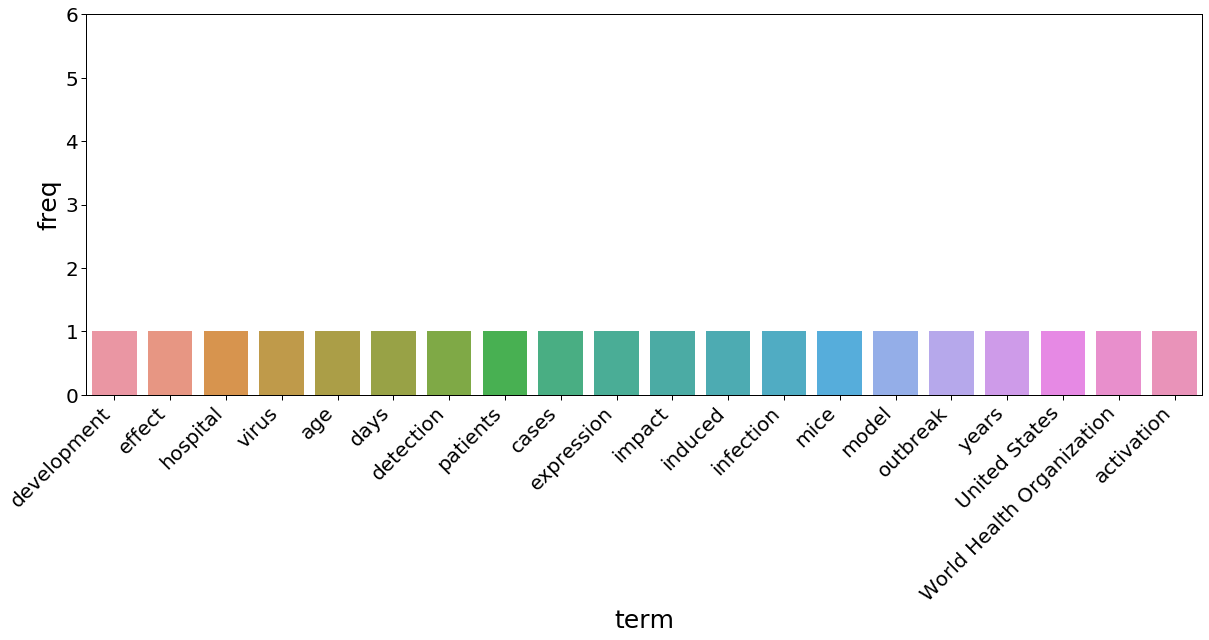

In [47]:
labelPerPeriod.createOrReplaceTempView("labelPerPeriod")

STARTING_YEAR = 2004

TOPPLOT = 20

period = str(STARTING_YEAR) + '-' + str(STARTING_YEAR+2)

labelOnePeriod = spark.sql(f"""
select term, freq
from labelPerPeriod
where period = '{period}'
order by rank
""")
# labelOnePeriod.show()

p = labelOnePeriod.toPandas()
# p.head(2)

sns.set_context("paper", rc={"axes.labelsize":25})   
plt.figure(figsize=(20,7))

# set a fixed range for the y axis
plt.ylim(0,6)

ax = sns.barplot(x="term", y="freq",  data=p[:TOPPLOT])

# size of values on axes
ax.tick_params(labelsize=20)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');


#### Frequent terms for 2 periods

In [48]:
L = labelPerPeriod.toPandas()
L.head(10)

,period,rank,term,freq
0,2002-2004,1,development,1
1,2002-2004,2,effect,1
2,2002-2004,3,hospital,1
3,2002-2004,4,virus,1
4,2002-2004,5,age,1
5,2002-2004,6,days,1
6,2002-2004,7,detection,1
7,2002-2004,8,patients,1
8,2002-2004,9,cases,1
9,2002-2004,10,expression,1


<Figure size 1440x504 with 0 Axes>

<Figure size 1440x504 with 0 Axes>

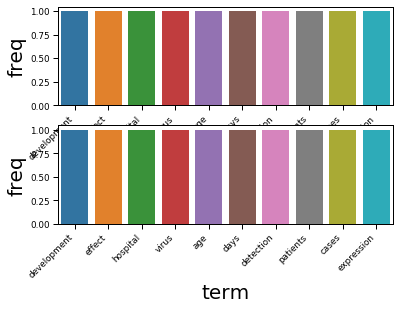

In [50]:
L1 = L[L.period=='2002-2004']
L2 = L[L.period=='2004-2006']

all = [L1, L2]

# TOPPLOT = 20


sns.set_context("paper", rc={"axes.labelsize":20})   
plt.figure(figsize=(20,7))

# set a fixed range for the y axis
plt.ylim(0,6)

# size of values on axes
ax.tick_params(labelsize=20)

plt.clf()
plt.figure(figsize=(20,7))
fig, axs = plt.subplots(2,1)
for i in range(0, 2):
    axs[i].set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
    sns.barplot(x="term", y="freq",  data=all[i][:10], ax=axs[i])


## Interaction

In [51]:
# interaction
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [52]:
widgets.Text("abc")

Text(value='abc')

##### Verify GUI for interaction

In [53]:
def f(x):
    return x*10

In [54]:
# from __future__ import print_function
# interact(f,x=10);
interact(f, x=widgets.IntSlider(min=-10, max=30, step=1, value=10));

100

In [55]:
out = widgets.Output(layout={'border': '1px solid black'})
with out:
    display(widgets.IntSlider())

out

IntSlider(value=0)

Output(layout=Layout(border='1px solid black'))

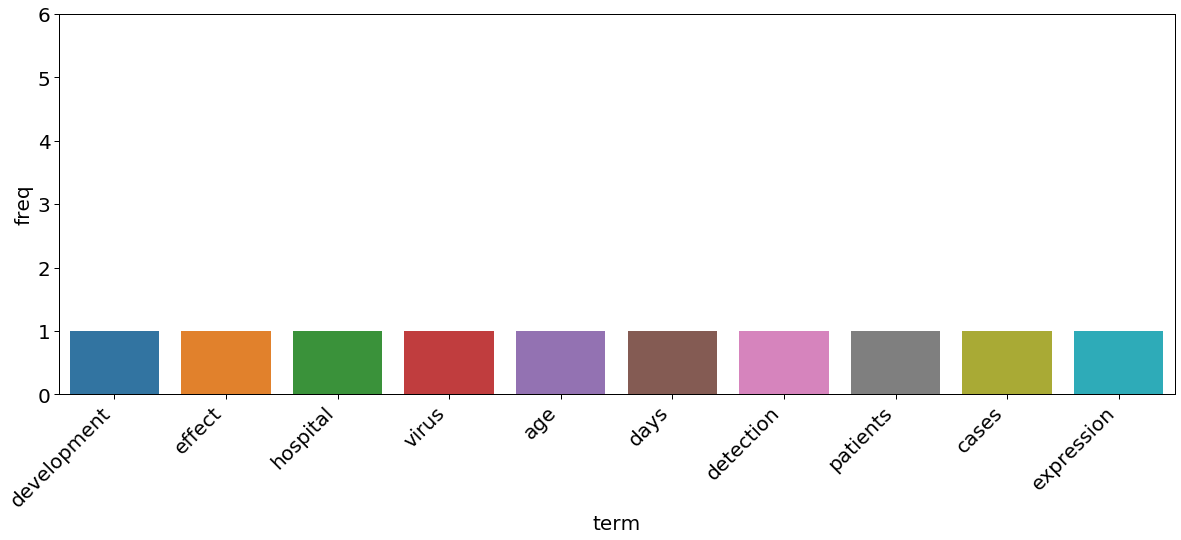

In [58]:
def plotLabelPerPeriod(startYear, topPlot):
    
    labelPerPeriod.createOrReplaceTempView("labelPerPeriod")

    period = str(startYear) + '-' + str(startYear+2)

    labelOnePeriod = spark.sql(f"""
    select term, freq
    from labelPerPeriod
    where period = '{period}'
    order by rank
    """)

    p = labelOnePeriod.toPandas()
    
    sns.set_context("paper", rc={"axes.labelsize":20})   
    plt.figure(figsize=(20,7))
    plt.ylim(0,6)
    ax = sns.barplot(x="term", y="freq",  data=p[:topPlot])
    
    # taille des valeurs sur les axes
    ax.tick_params(labelsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

    
def plotLabelPerPeriodDEBUG(startYear, topPlot):
    print(startYear)
    print(topPlot)


print("defined")
    
START_YEAR = 2002
TOPPLOT = 10

# plotLabelPerPeriod(START_YEAR, TOPPLOT)

startYearWidget= widgets.IntSlider(
    value=2002,
    min=2002,
    max=2019,
    step=2,
    description='Period:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

topPlotWidget= widgets.IntSlider(
    value=10,
    min=10,
    max=40,
    step=5,
    description='#terms',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)


# interact(plotLabelPerPeriodDEBUG, startYear=startYearWidget, topPlot=topPlotWidget);
interact(plotLabelPerPeriod, startYear=startYearWidget, topPlot=topPlotWidget);


In [59]:
period = spark.sql("""
select distinct period
from topicPeriod
order by period
""")
period.show()


+---------+
|   period|
+---------+
|2002-2004|
|2004-2006|
|2006-2008|
|2008-2010|
|2010-2012|
|2012-2014|
|2014-2016|
|2016-2018|
|2018-2019|
+---------+

